# Chatbot Evaluation #

In [15]:
#General imports
import pandas as pd
import time
from importlib import reload
import evaltools
reload(evaltools)
from sqltr import SQLTestRun
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

import numpy as np


In [2]:
#read input test file:
init_df = pd.read_csv('./data/eval_set.csv')
init_df

,is_sql,num_join,indirect_level,difficulty_level,specified_response_field,text_query,expected_sql
0,1,0,0.5,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...
1,1,1,0.5,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ..."
2,1,1,0.5,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr..."
3,1,0,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer
4,1,0,0.5,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am..."
5,1,0,0.0,0.0,0.0,What playlists are there?,SELECT name from playlist
6,1,1,0.5,1.5,1.0,"Who reports to Andrew Adams, provide the name ...","SELECT CONCAT(last_name, ', ', first_name) AS..."
7,1,2,0.5,2.5,1.0,List all the play_list_name and track_name of ...,"SELECT distinct P.name as play_list_name, T.na..."
8,1,0,0.0,0.0,0.0,How many staff does the store have?,SELECT COUNT(*) from employee
9,0,0,NaN,NaN,NaN,Are we ready?,NaN


In [3]:
#setup parameters, then permute the test rows of all combinations of the parameters

methods = ["rag", "tag"]
providers = ["OpenAI", "Claude"]
temperatures = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


combinations = [
    {"method": method, "provider": provider, "temperature": temperature}
    for method, provider, temperature in product(methods, providers, temperatures)
]

### Section 1: Initial Query Evaluation ###

In this section we evaluate: 

    1. Latency of query generation. 
    2. Whether the generation result are SQL if the user query is translatable to SQL, or error message if the user query is not SQL query related.
    3. For text query that can be translated into SQL, evaluate whehter the SQL is valid PostGRESQL SQL, if not, report what error. 

In [4]:

#initialize dataframe with generation_latency and isValidSQL captured
df_rows = []

for combination in combinations:
    method = combination["method"]
    provider = combination["provider"]
    temperature = combination["temperature"]
    
    for i in range(len(init_df)):
        text_query = init_df.iloc[i]['text_query']
        expected_sql = init_df.iloc[i]['expected_sql']
        expected_is_query = (init_df.iloc[i]['is_sql'] == 1)
        difficulty = init_df.iloc[i]['difficulty_level']
        specified_response_field = init_df.iloc[i]['specified_response_field']
 
        if(method == "rag"):
            start_time = time.perf_counter()
            generated_sql = evaltools.gen_rag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
        else:
            start_time = time.perf_counter()
            generated_sql = await evaltools.gen_tag_query(text_query, provider, temperature)
            end_time = time.perf_counter()
            
        generation_latency = (end_time - start_time)*1000 # convert seconds to milli seconds
        generated_is_sql = evaltools.is_sql_check(generated_sql)

        is_type_correct = evaltools.confirm_type(generated_sql, expected_is_query)
        if(generated_is_sql):
            lintEval = evaltools.check_sql_errors(generated_sql)
            isValidSQL = lintEval["isValid"]
            formatIssue = lintEval["errMessage"]
        else: 
            isValidSQL = "N/A"
            formatIssue = "N/A"

        new_row = {
            "method": method, "provider": provider, "temperature": temperature, "difficulty": difficulty,"specified_response_field":specified_response_field,
            "text_query": text_query, "expected_sql": expected_sql, "expected_is_query": expected_is_query,
            "generated_sql": generated_sql, "generated_is_sql": generated_is_sql, "is_type_correct": is_type_correct,
            "generation_latency": generation_latency, "isValidSQL": isValidSQL, "formatIssue": formatIssue
        }
        # Append the row
        df_rows.append(new_row)
        

eval_df = pd.DataFrame(df_rows)


base_dire is:  /home/kengqiangmk/Projects/chat-to-database-chatbot


Parsing nodes:   0%|          | 0/2 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Invalid expression / Unexpected token. Line 1, Col: 17.
  SELECT statement: SELECT * FROM some_table;
response:- The query results will show all invoices, along with their respective invoice ID, customer ID, invoice date, and total, that were made on Christmas Eve, Christmas Day, Boxing Day, New Year's Eve, and New Year's Day. The results will be ordered by the invoice date.
Generated SQL:- SELECT invoice_id, customer_id, invoice_date, total 
FROM invoice 
WHERE invoice_date::date IN ('2022-12-24', '2022-12-25', '2022-12-26', '2022-12-31', '2023-01-01')
ORDER BY invoice_date;
valid_sql:- True
response:- The top 3 artists by total albums cannot be determined as the query results are not provided.
Generated SQL:- SELECT artist.name, COUNT(album.album_id) AS total_albums
FROM artist
JOIN album ON artist.artist_id = album.artist_id
GROUP BY artist.name
ORDER BY total_albums DESC
LIMIT 3;
valid_sql:- True
response:- The query results provide a list of classical composers along with the aver

In [5]:
eval_df.head()

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,11331.848870,True,
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3482.029650,True,
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT track.composer, AVG(track.milliseconds)...",True,True,2719.043727,True,
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,2115.596503,True,
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,2530.135310,True,


In [5]:
# eval_df.to_csv("eval_df.csv", index=False)

/tmp/ipykernel_322117/4232421725.py:31: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image1 = np.frombuffer(g1.figure.canvas.tostring_rgb(), dtype=np.uint8)
/tmp/ipykernel_322117/4232421725.py:37: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image2 = np.frombuffer(g2.figure.canvas.tostring_rgb(), dtype=np.uint8)


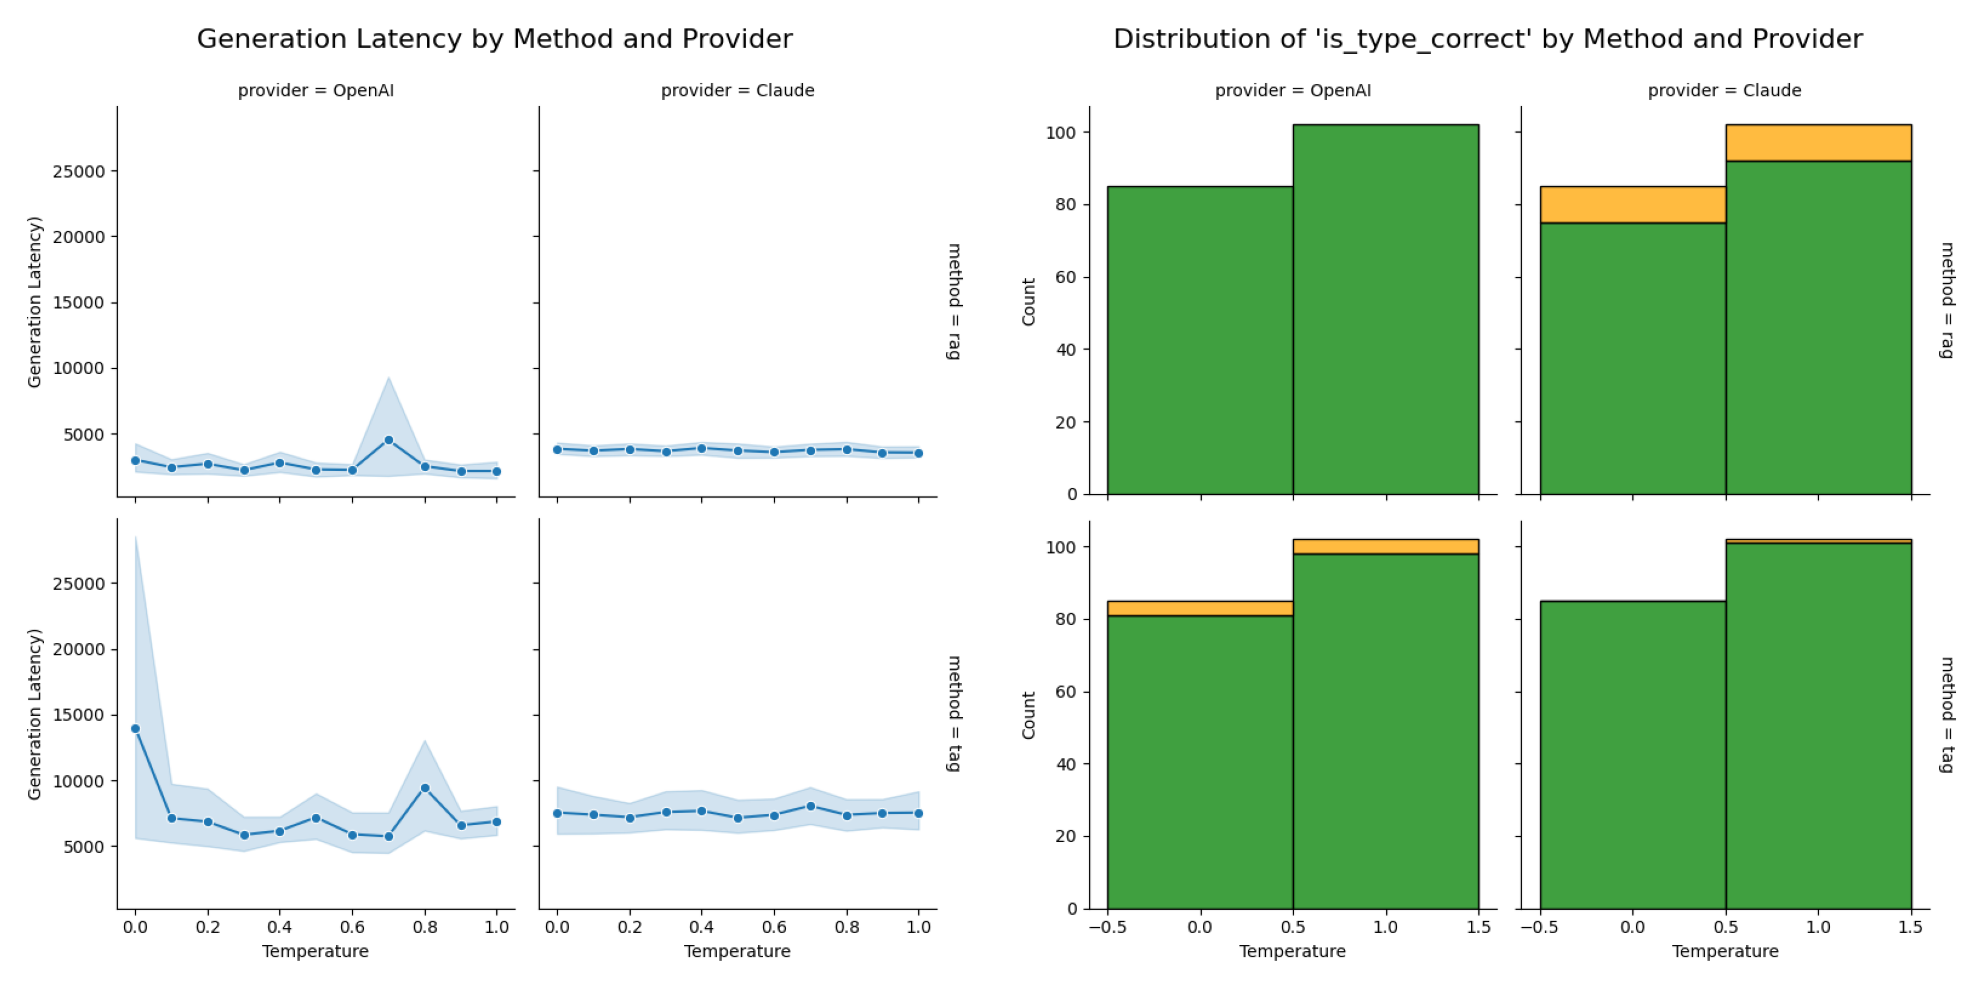

In [6]:
#generate latency and type correctness plots
g1 = sns.FacetGrid(eval_df, row="method", col="provider", margin_titles=True, height=4, aspect=1)
g1.map_dataframe(sns.lineplot, x="temperature", y="generation_latency", marker="o")
g1.set_axis_labels("Temperature", "Generation Latency)")
g1.set_titles("{row_name} | {col_name}")
g1.figure.subplots_adjust(top=0.9)
g1.figure.suptitle("Generation Latency by Method and Provider", fontsize=16)

plt.close(g1.figure)

custom_palette = {True: "green", False: "orange"}
g2 = sns.FacetGrid(eval_df, row="method", col="provider", margin_titles=True, height=4, aspect=1)
g2.map_dataframe(
    sns.histplot,
    x="temperature",
    hue="is_type_correct",
    multiple="stack",
    discrete=True,
    palette=custom_palette,
)
g2.set_axis_labels("Temperature", "Count")
g2.set_titles("{row_name} | {col_name}")
g2.figure.subplots_adjust(top=0.9)
g2.figure.suptitle("Distribution of 'is_type_correct' by Method and Provider", fontsize=16)

plt.close(g2.figure)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

g1.figure.canvas.draw()
image1 = np.frombuffer(g1.figure.canvas.tostring_rgb(), dtype=np.uint8)
image1 = image1.reshape(g1.figure.canvas.get_width_height()[::-1] + (3,))
axs[0].imshow(image1)
axs[0].axis("off")  # Turn off axes for the FacetGrid plot

g2.figure.canvas.draw()
image2 = np.frombuffer(g2.figure.canvas.tostring_rgb(), dtype=np.uint8)
image2 = image2.reshape(g2.figure.canvas.get_width_height()[::-1] + (3,))
axs[1].imshow(image2)
axs[1].axis("off")  # Turn off axes for the FacetGrid plot

plt.tight_layout()
plt.show()

### Further Analyze Queries that Can be Translated to SQL ###

In [26]:
# filter out only the rows where SQL is generated. 
sql_df = eval_df[(eval_df['generated_is_sql'] == True) & (eval_df['expected_is_query'] == True)].copy()

In [17]:
sql_df.head(10)

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,11331.848870,True,
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3482.029650,True,
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT track.composer, AVG(track.milliseconds)...",True,True,2719.043727,True,
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,2115.596503,True,
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,2530.135310,True,
5,rag,OpenAI,0.0,0.0,0.0,What playlists are there?,SELECT name from playlist,True,SELECT name FROM playlist;,True,True,1073.522213,True,
6,rag,OpenAI,0.0,1.5,1.0,"Who reports to Andrew Adams, provide the name ...","SELECT CONCAT(last_name, ', ', first_name) AS...",True,"SELECT last_name || ', ' || first_name AS name...",True,True,2595.685730,True,
7,rag,OpenAI,0.0,2.5,1.0,List all the play_list_name and track_name of ...,"SELECT distinct P.name as play_list_name, T.na...",True,"SELECT playlist.name AS play_list_name, track....",True,True,3203.557114,True,
8,rag,OpenAI,0.0,0.0,0.0,How many staff does the store have?,SELECT COUNT(*) from employee,True,SELECT COUNT(*) FROM employee;,True,True,1065.863662,True,
12,rag,OpenAI,0.0,4.0,1.0,What are the customer first_name and last_name...,"SELECT distinct c.first_name, c.last_name from...",True,"SELECT customer.first_name, customer.last_name...",True,True,5498.779277,True,


In [27]:
sqlTestRun = SQLTestRun()

In [28]:

#Calculate Metric Scores
for i, row in sql_df.iterrows():
    expected_sql = row['expected_sql']
    generated_sql = row['generated_sql']
    if row['isValidSQL']:
        valid_score = 1
    else: 0

    sql_sim_score = evaltools.sql_compare_score(expected_sql, generated_sql)
    sql_length_score = evaltools.sql_length_score(expected_sql, generated_sql)

    edf = sqlTestRun.run_sql_result(expected_sql)
    gdf = sqlTestRun.run_sql_result(generated_sql)

    try:
        edf = sqlTestRun.run_sql_result(expected_sql)
        gdf = sqlTestRun.run_sql_result(generated_sql)
        qr_response_comp_score = evaltools.qr_compare(edf, gdf)
        cosin_sim_score = evaltools.cosin_sim(edf, gdf)
    except Exception as e:
        qr_response_comp_score = {"cols_sim_score": 0, "rows_sim_score": 0, "total_sim_score": 0}

    qr_response_score = qr_response_comp_score.get("total_sim_score")

    
    total_score = ((cosin_sim_score*0.2)+(sql_sim_score*0.2)+(sql_length_score*0.01)+(qr_response_score*0.6))*valid_score

    sql_df.loc[i, 'sql_sim_score'] = sql_sim_score
    sql_df.loc[i, 'sql_length_score'] = sql_length_score
    sql_df.loc[i, 'qr_response_score'] = qr_response_score
    sql_df.loc[i, 'cosin_sim_score'] = cosin_sim_score
    sql_df.loc[i, 'total_score'] = total_score

Error: column reference "artist_id" is ambiguous
LINE 1: SELECT artist_id, name, COUNT(album_id) AS total_albums FROM...
               ^

Error: column reference "artist_id" is ambiguous
LINE 1: SELECT artist_id, name, COUNT(album_id) AS total_albums FROM...
               ^

exception happened,  'NoneType' object has no attribute 'columns'
Error: column reference "artist_id" is ambiguous
LINE 1: SELECT artist_id, name, COUNT(album_id) AS total_albums FROM...
               ^

Error: column reference "artist_id" is ambiguous
LINE 1: SELECT artist_id, name, COUNT(album_id) AS total_albums FROM...
               ^

exception happened,  'NoneType' object has no attribute 'columns'
Error: relation "tracks" does not exist
LINE 1: ..., AVG(t.milliseconds) AS avg_track_length_ms FROM tracks t W...
                                                             ^

Error: relation "tracks" does not exist
LINE 1: ..., AVG(t.milliseconds) AS avg_track_length_ms FROM tracks t W...
                  

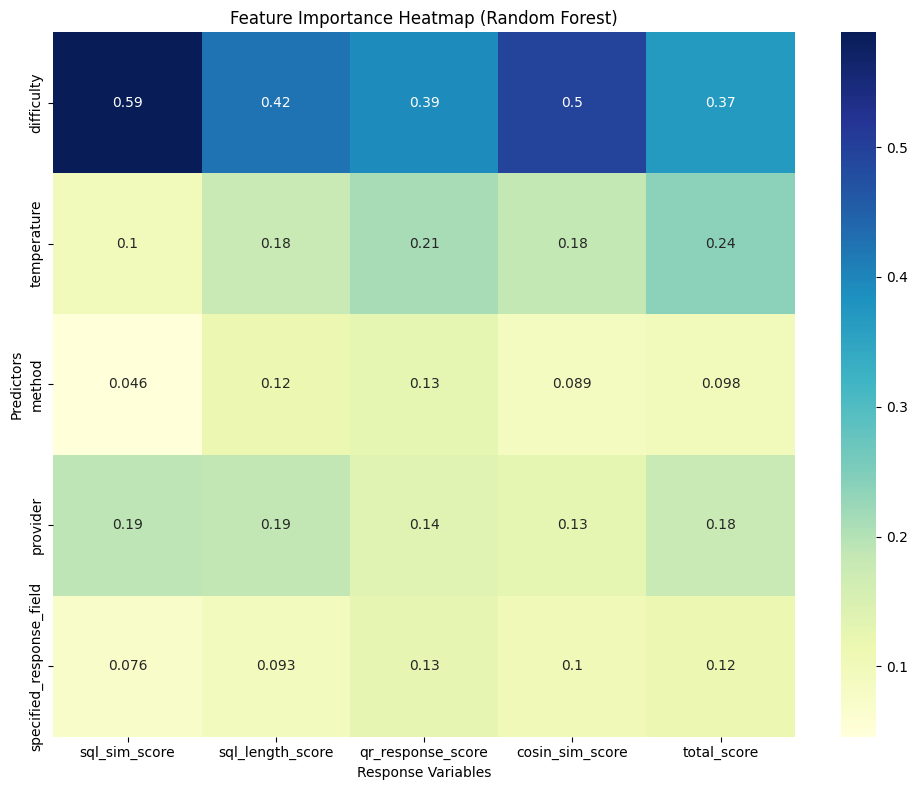

In [20]:
#Create Feature Importance Heatmap:
predictors = ['difficulty', 'temperature', 'method', 'provider', 'specified_response_field']
response_vars = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'cosin_sim_score', 'total_score']

data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

importances = {}

for response in response_vars:
    X = data_encoded[predictors]  
    y = data_encoded[response]   

    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    importances[response] = model.feature_importances_

importance_df = pd.DataFrame(importances, index=predictors)

plt.figure(figsize=(10, 8))
sns.heatmap(importance_df, annot=True, cmap="YlGnBu", cbar=True) 
plt.title("Feature Importance Heatmap (Random Forest)")
plt.xlabel("Response Variables")
plt.ylabel("Predictors")
plt.tight_layout()
plt.show()

In [12]:
#OLS for total_score
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

response = 'total_score'  
predictors = ['provider', 'temperature', 'difficulty', 'method'] 
# predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("model p-values:", model.pvalues)
print(model.summary())

model p-values: const          1.082453e-08
provider       2.274985e-02
temperature    4.291539e-01
difficulty     8.276017e-11
method                  NaN
dtype: float64
                            OLS Regression Results                            
Dep. Variable:            total_score   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     17.00
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.12e-10
Time:                        15:09:32   Log-Likelihood:                -253.71
No. Observations:                 307   AIC:                             515.4
Df Residuals:                     303   BIC:                             530.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err      

/home/kengqiangmk/Projects/chat-to-database-chatbot/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [13]:
#OLS for cosin_sim_score
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

response = 'cosin_sim_score'  
predictors = ['provider', 'temperature', 'difficulty', 'method', 'specified_response_field'] 
# predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("model p-values:", model.pvalues)
print(model.summary())

model p-values: const                       2.552023e-14
provider                    6.064037e-01
temperature                 9.564350e-01
difficulty                  2.841147e-04
method                               NaN
specified_response_field    7.017440e-01
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        cosin_sim_score   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     4.609
Date:                Mon, 09 Dec 2024   Prob (F-statistic):            0.00126
Time:                        15:09:32   Log-Likelihood:                -133.26
No. Observations:                 307   AIC:                             276.5
Df Residuals:                     302   BIC:                             295.1
Df Model:                           4                                         
Covariance T

/home/kengqiangmk/Projects/chat-to-database-chatbot/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [14]:

#OLS for sql_length_score
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

response = 'sql_length_score'  
predictors = ['provider', 'temperature', 'difficulty', 'method'] 
# predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("model p-values:", model.pvalues)
print(model.summary())

model p-values: const          1.036466e-04
provider       2.782166e-02
temperature    3.062796e-01
difficulty     1.255177e-09
method                  NaN
dtype: float64
                            OLS Regression Results                            
Dep. Variable:       sql_length_score   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     15.02
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.88e-09
Time:                        15:09:32   Log-Likelihood:                -1580.8
No. Observations:                 307   AIC:                             3170.
Df Residuals:                     303   BIC:                             3185.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err      

/home/kengqiangmk/Projects/chat-to-database-chatbot/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [15]:
#OLS for sql_sim_score
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

response = 'sql_sim_score'  
predictors = ['provider', 'temperature', 'difficulty', 'method'] 
# predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("model p-values:", model.pvalues)
print(model.summary())

model p-values: const          7.904736e-91
provider       4.145847e-03
temperature    3.399437e-01
difficulty     2.476056e-22
method                  NaN
dtype: float64
                            OLS Regression Results                            
Dep. Variable:          sql_sim_score   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     39.97
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           8.58e-22
Time:                        15:09:32   Log-Likelihood:                 45.434
No. Observations:                 307   AIC:                            -82.87
Df Residuals:                     303   BIC:                            -67.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err      

/home/kengqiangmk/Projects/chat-to-database-chatbot/venv/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [16]:

#OLS for qr_response_score
data_encoded = sql_df.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

response = 'qr_response_score'  
predictors = ['provider', 'method','temperature', 'difficulty', 'specified_response_field'] 
# predictors = ['provider', 'method','temperature'] 
# Prepare data for regression
X = data_encoded[predictors]  
y = data_encoded[response]    
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("model p-values:", model.pvalues)
print(model.summary())

# model.summary()

model p-values: const                       1.886115e-29
provider                    4.344275e-01
method                      5.996748e-02
temperature                 8.877233e-01
difficulty                  2.544659e-02
specified_response_field    3.786105e-02
dtype: float64
                            OLS Regression Results                            
Dep. Variable:      qr_response_score   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.800
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.129
Time:                        15:09:32   Log-Likelihood:                -148.37
No. Observations:                 307   AIC:                             306.7
Df Residuals:                     302   BIC:                             325.4
Df Model:                           4                                         
Covariance T

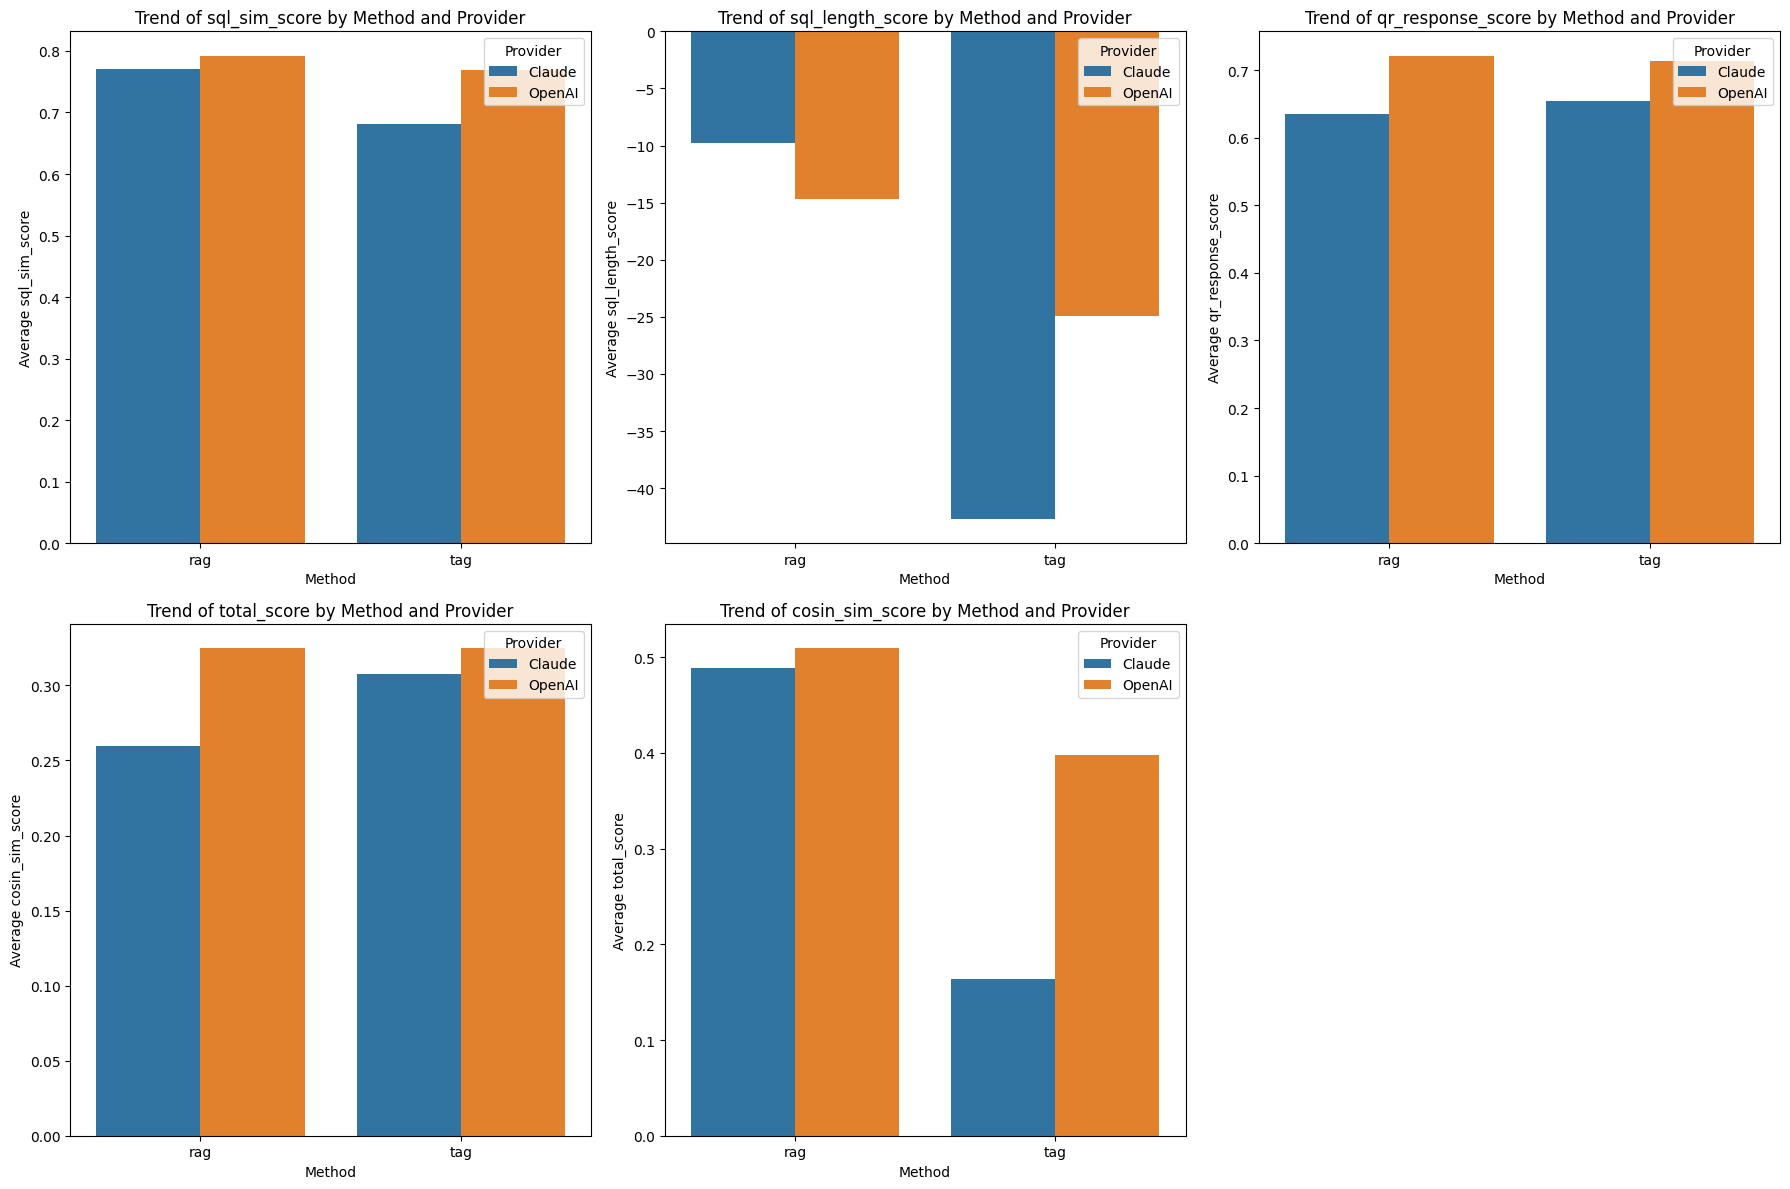

In [21]:
#Response Variable Trends by Category
data = sql_df.copy()
response_vars = ['sql_sim_score', 'sql_length_score', 'qr_response_score','cosin_sim_score', 'total_score']

# Encode categorical variables
data_encoded = data.copy()
data_encoded['method'] = data_encoded['method'].astype('category').cat.codes
data_encoded['provider'] = data_encoded['provider'].astype('category').cat.codes

# Group data by method and provider, calculating the mean for each response variable
grouped_data = data_encoded.groupby(['method', 'provider'])[response_vars].mean().reset_index()

method_mapping = dict(enumerate(data['method'].astype('category').cat.categories))
provider_mapping = dict(enumerate(data['provider'].astype('category').cat.categories))
grouped_data['method'] = grouped_data['method'].map(method_mapping)
grouped_data['provider'] = grouped_data['provider'].map(provider_mapping)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12)) 
axes = axes.flatten()  


titles = [
    "Trend of sql_sim_score by Method and Provider",
    "Trend of sql_length_score by Method and Provider",
    "Trend of qr_response_score by Method and Provider",
    "Trend of total_score by Method and Provider",
    "Trend of cosin_sim_score by Method and Provider"
]


for i, response in enumerate(response_vars):
    sns.barplot(
        x='method', y=response, hue='provider', data=grouped_data,
        palette='tab10', ax=axes[i]
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Method")
    axes[i].set_ylabel(f"Average {response}")
    axes[i].legend(title="Provider", loc='upper right')


if len(response_vars) < len(axes):
    for j in range(len(response_vars), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipykernel_322117/2769571345.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
/tmp/ipykernel_322117/2769571345.py:16: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
/tmp/ipykernel_322117/2769571345.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sql_df, x='provider', y=response, ax=axes[i, 1], palette=boxplot_palette)
/tmp/ipykernel_322117/2769571345.py:22: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxpl

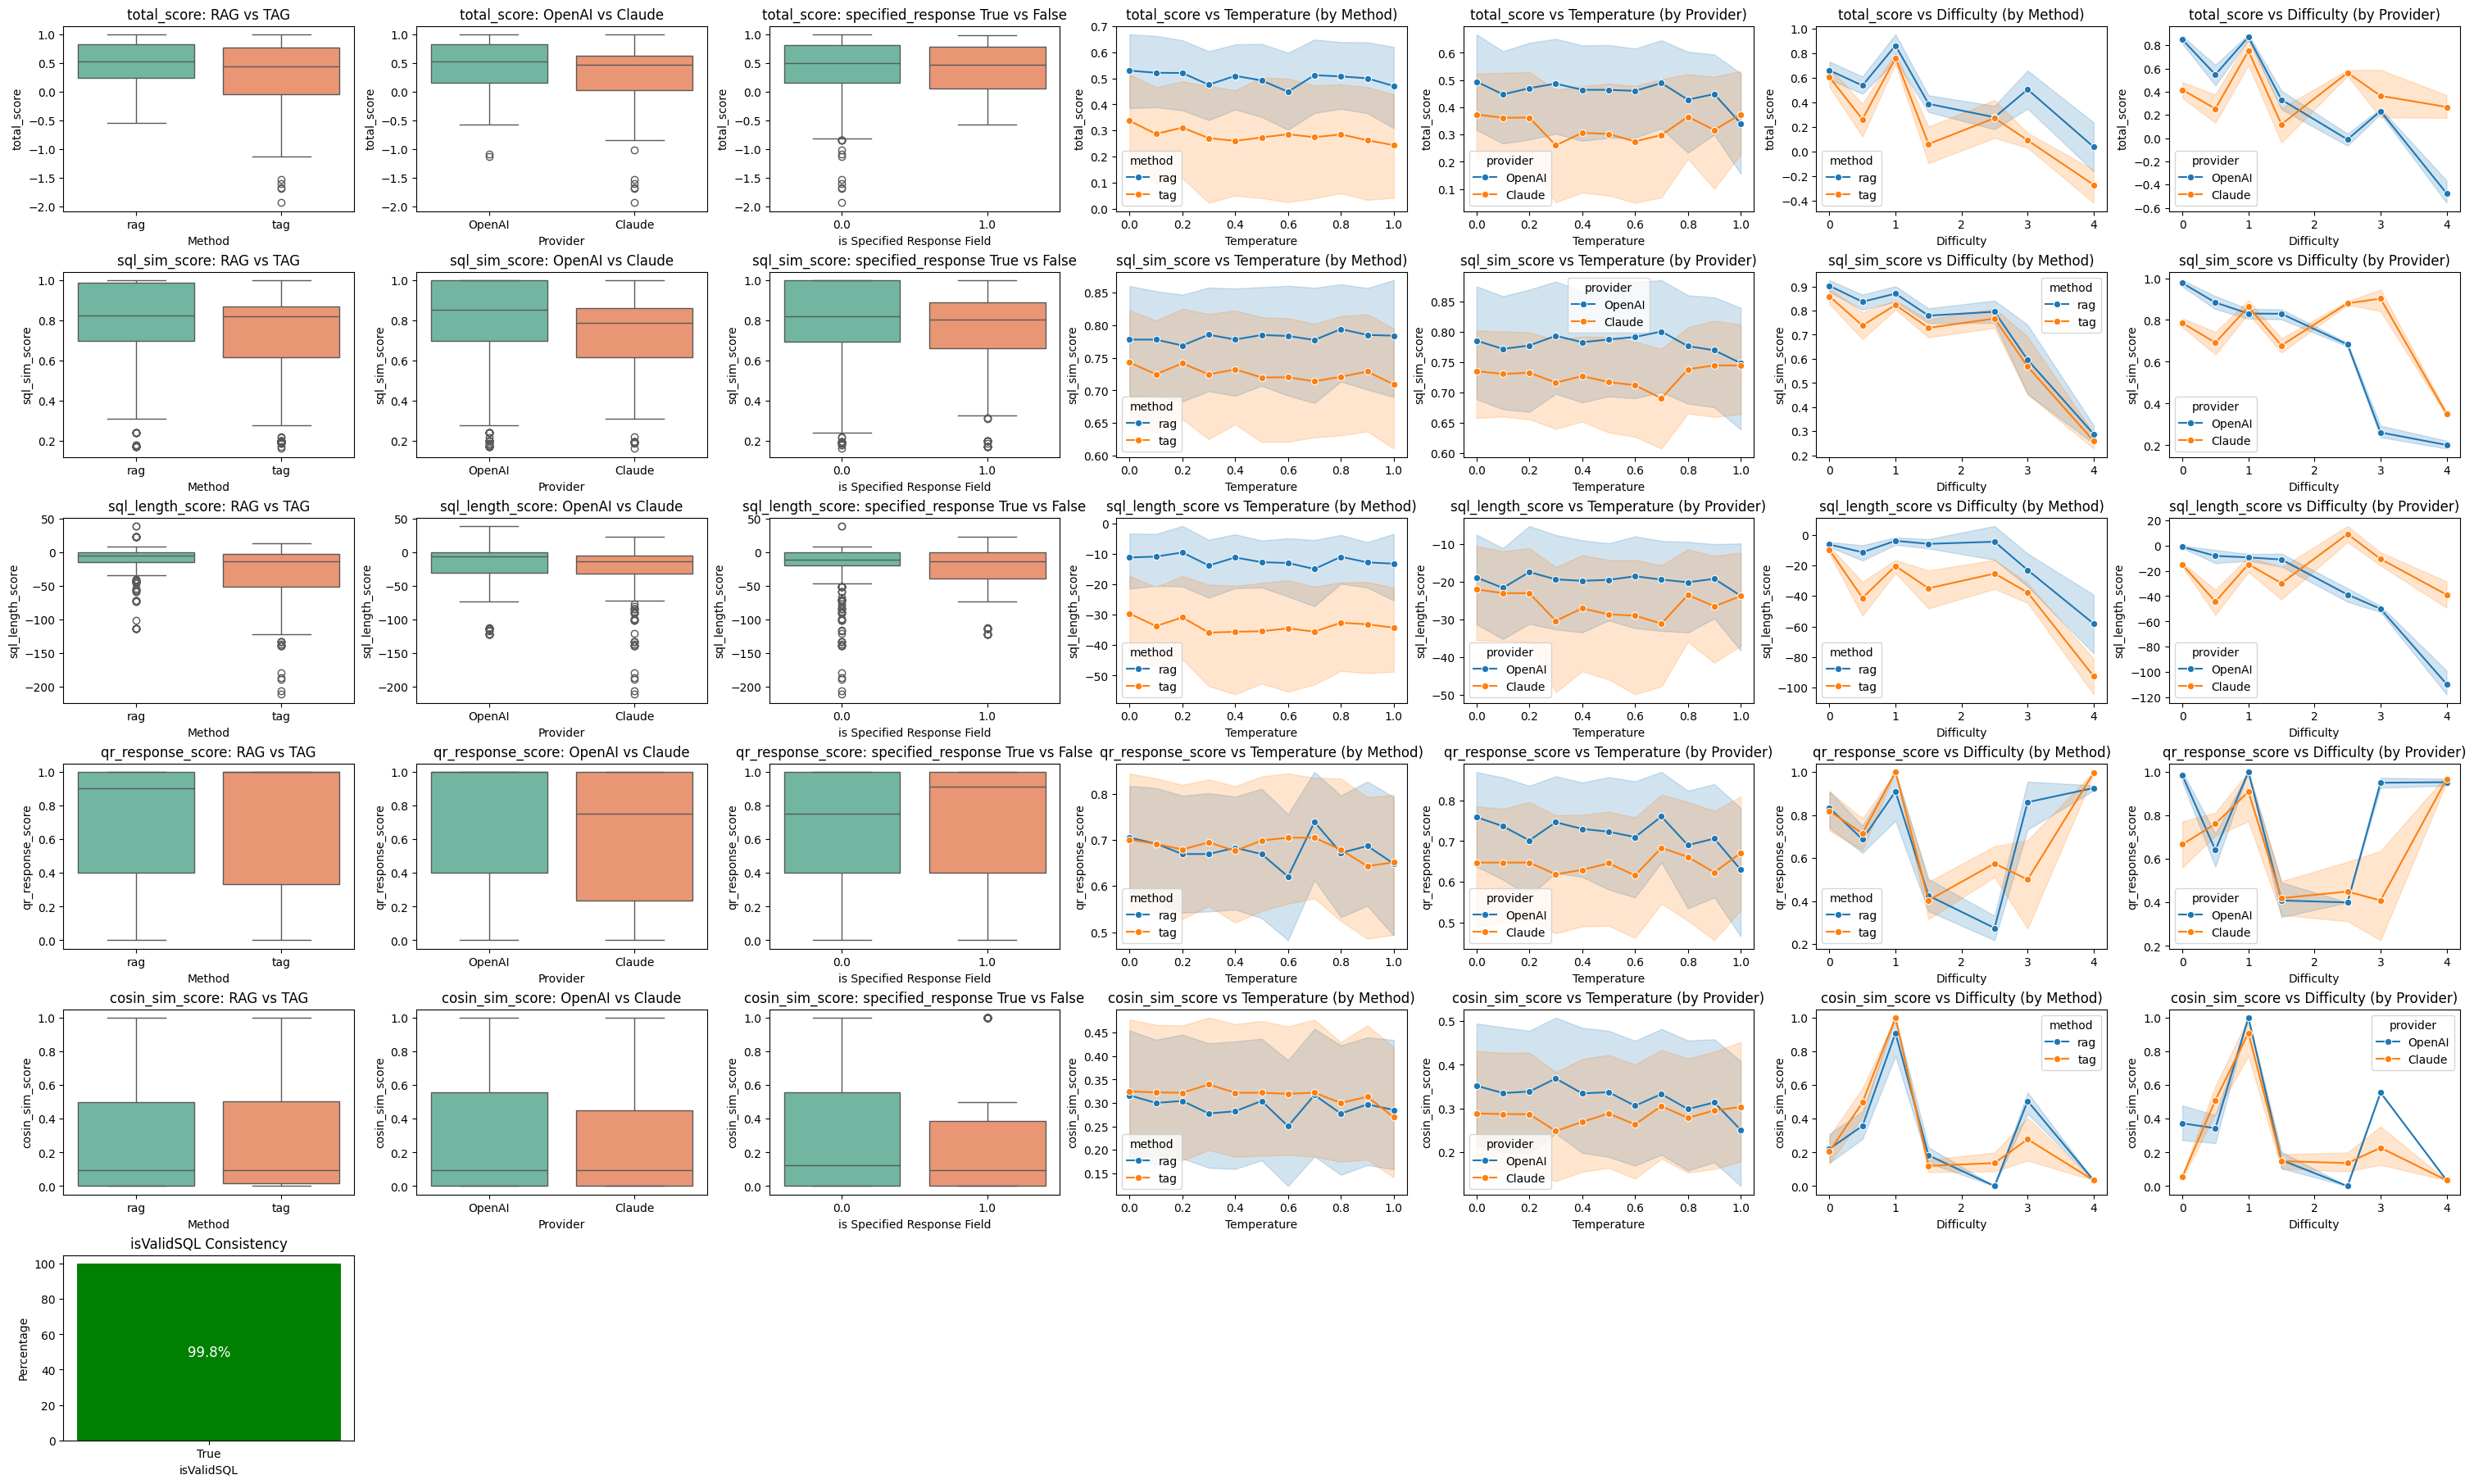

In [22]:

#marginal effect of features upon the metrics. check whether metrics value changes as temperature or difficulty change
# List of response variables
response_vars = ['total_score', 'sql_sim_score', 'sql_length_score', 'qr_response_score', 'cosin_sim_score']

# Total number of rows
n_responses = len(response_vars) + 1

# Create a grid of subplots
fig, axes = plt.subplots(n_responses, 7, figsize=(30, 3 * n_responses), constrained_layout=True)

# Color
boxplot_palette = sns.color_palette(["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854"])

for i, response in enumerate(response_vars):
    # Marginal boxplot for RAG vs TAG
    sns.boxplot(data=sql_df, x='method', y=response, ax=axes[i, 0], palette=boxplot_palette)
    axes[i, 0].set_title(f'{response}: RAG vs TAG')
    axes[i, 0].set_xlabel('Method')
    axes[i, 0].set_ylabel(response)
    
    # Marginal boxplot for OpenAI vs Claude
    sns.boxplot(data=sql_df, x='provider', y=response, ax=axes[i, 1], palette=boxplot_palette)
    axes[i, 1].set_title(f'{response}: OpenAI vs Claude')
    axes[i, 1].set_xlabel('Provider')
    axes[i, 1].set_ylabel(response)

    # Marginal boxplot for specified_response_field true vs false
    sns.boxplot(data=sql_df, x='specified_response_field', y=response, ax=axes[i, 2], palette=boxplot_palette)
    axes[i, 2].set_title(f'{response}: specified_response True vs False')
    axes[i, 2].set_xlabel('is Specified Response Field')
    axes[i, 2].set_ylabel(response)
    
    # Line plot of response changes with temperature (by method)
    sns.lineplot(data=sql_df, x='temperature', y=response, hue='method', ax=axes[i, 3], marker='o')
    axes[i, 3].set_title(f'{response} vs Temperature (by Method)')
    axes[i, 3].set_xlabel('Temperature')
    axes[i, 3].set_ylabel(response)
    
    # Line plot of response changes with temperature (by provider)
    sns.lineplot(data=sql_df, x='temperature', y=response, hue='provider', ax=axes[i, 4], marker='o')
    axes[i, 4].set_title(f'{response} vs Temperature (by Provider)')
    axes[i, 4].set_xlabel('Temperature')
    axes[i, 4].set_ylabel(response)

    # Line plot of response changes with difficulty (by method)
    sns.lineplot(data=sql_df, x='difficulty', y=response, hue='method', ax=axes[i, 5], marker='o')
    axes[i, 5].set_title(f'{response} vs Difficulty (by Method)')
    axes[i, 5].set_xlabel('Difficulty')
    axes[i, 5].set_ylabel(response)
    
    # Line plot of response changes with temperature (by provider)
    sns.lineplot(data=sql_df, x='difficulty', y=response, hue='provider', ax=axes[i, 6], marker='o')
    axes[i, 6].set_title(f'{response} vs Difficulty (by Provider)')
    axes[i, 6].set_xlabel('Difficulty')
    axes[i, 6].set_ylabel(response)    

total_rows = len(sql_df)
is_valid_sql_percentage = (sql_df["isValidSQL"].sum() / total_rows) * 100

axes[-1, 0].bar(["True"], [is_valid_sql_percentage], color="green")
axes[-1, 0].set_title("isValidSQL Consistency")
axes[-1, 0].set_ylabel("Percentage")
axes[-1, 0].set_xlabel("isValidSQL")
axes[-1, 0].text(0, is_valid_sql_percentage / 2, f"{is_valid_sql_percentage:.1f}%", ha="center", va="center", color="white", fontsize=12)

# Clear unused subplots in the last row
for ax in axes[-1, 1:]:
    ax.axis("off")

plt.show()


In [23]:
print(sql_df[(sql_df['isValidSQL'] == 0)][["generated_sql", "provider"]]) # sometimes Claude generate replies with redundant values. 

                                         generated_sql provider
544  SELECT invoice_id, customer_id, invoice_date, ...   OpenAI


In [24]:
sql_df.head()

,method,provider,temperature,difficulty,specified_response_field,text_query,expected_sql,expected_is_query,generated_sql,generated_is_sql,is_type_correct,generation_latency,isValidSQL,formatIssue,sql_sim_score,sql_length_score,qr_response_score,cosin_sim_score,total_score
0,rag,OpenAI,0.0,0.5,0.0,Show all invoices that were made during Christ...,SELECT * FROM invoice WHERE (TO_CHAR(invoice_d...,True,SELECT * FROM invoice WHERE invoice_date IN ('...,True,True,11331.848870,True,,0.780000,-6.0,0.52,0.452510,0.498502
1,rag,OpenAI,0.0,1.5,0.0,Find the top 3 artists by total albums,"SELECT AR.name, COUNT(AR.name) as TotalAlbums ...",True,"SELECT artist.name, COUNT(album.album_id) AS t...",True,True,3482.029650,True,,0.817869,-15.0,0.75,0.333333,0.530241
2,rag,OpenAI,0.0,1.5,0.0,list classic composers and their corresponding...,"SELECT T.composer, AVG(T.milliseconds) from tr...",True,"SELECT track.composer, AVG(track.milliseconds)...",True,True,2719.043727,True,,0.768116,-24.0,0.40,0.000000,0.153623
3,rag,OpenAI,0.0,0.0,0.0,list all the countries our customers are from,SELECT distinct country from customer,True,SELECT DISTINCT country FROM customer;,True,True,2115.596503,True,,1.000000,0.0,1.00,0.041667,0.808333
4,rag,OpenAI,0.0,0.5,1.0,What is the total invoice amount as total_amou...,"SELECT billing_country, SUM(total) as total_am...",True,"SELECT billing_country, SUM(total) AS total_am...",True,True,2530.135310,True,,1.000000,0.0,1.00,0.096254,0.819251


Current formula: y = -7337906474876.39
(-19342309167759.59) * method_rag + (-19342309167759.68) * method_tag
(26680215642636.91) * provider_Claude + (26680215642636.93) * provider_OpenAI
(-0.12) * difficulty
Current formula: y = -294590904388912.62
(294590904388912.25) * method_rag + (294590904388890.56) * method_tag
(-10.54) * difficulty
Current formula: y = 10628149776622.21
(-10628149776621.57) * provider_Claude + (-10628149776621.47) * provider_OpenAI
Current formula: y = -1640470040386.30
(1642096536160.34) * provider_Claude + (1642096536160.48) * provider_OpenAI
(-1626495773.43) * method_rag + (-1626495773.65) * method_tag
(-0.15) * difficulty
Current formula: y = 6716511063299.33
(-6716511063298.97) * provider_Claude + (-6716511063298.95) * provider_OpenAI
(-0.06) * difficulty


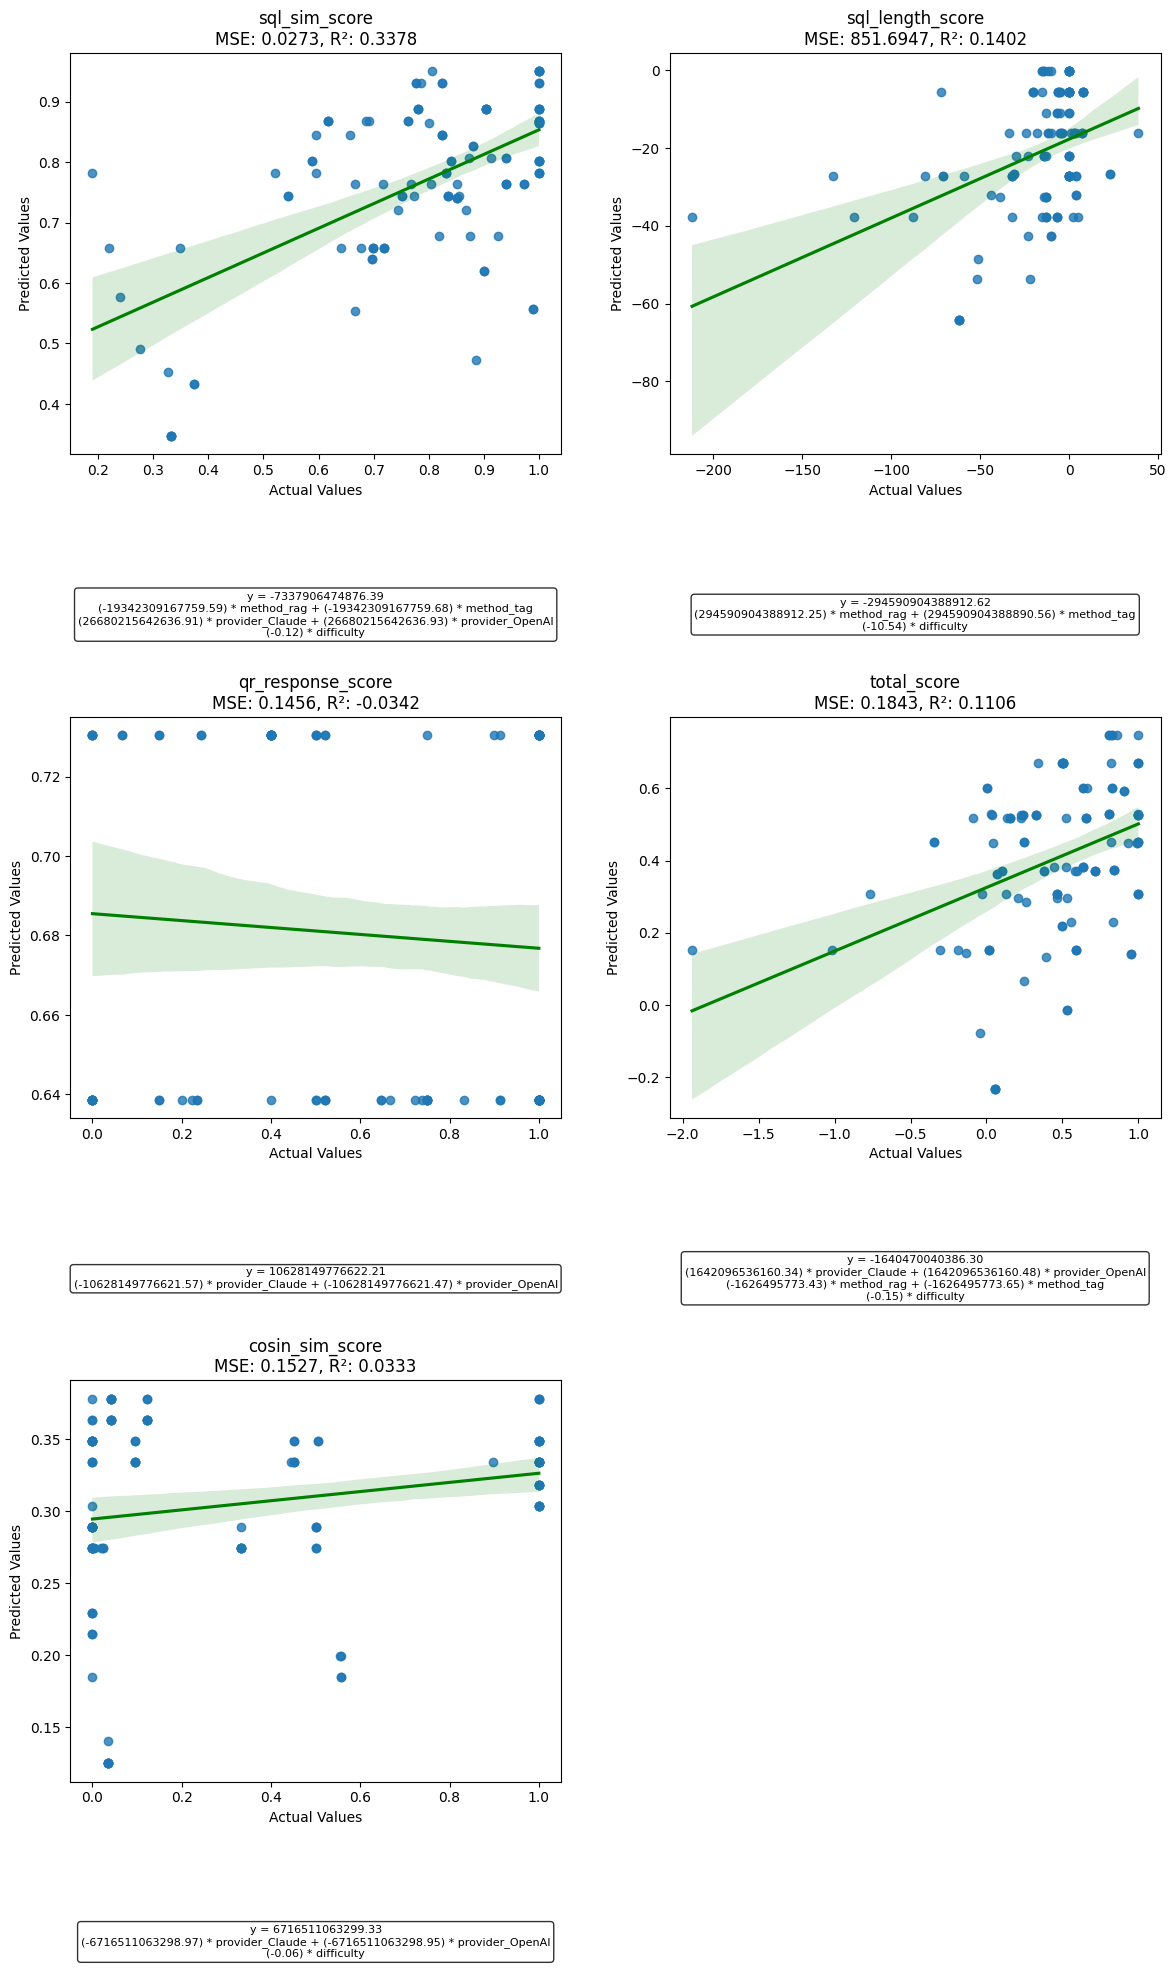

In [25]:
# regression
def analyze_and_sub_plot(ax, response_var, predicts_var, encode_var, passthrough_var):

    X = sql_df[predicts_var]
    y = sql_df[response_var]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(), encode_var),
        ],
        remainder='passthrough'
    )

    # Define pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    # Performance metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Extract feature names
    transformed_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    passthrough_features = passthrough_var if passthrough_var else []
    all_feature_names = list(transformed_feature_names) + passthrough_features

    # Validate feature-coefficient alignment
    coefficients = pipeline.named_steps['regressor'].coef_
    intercept = pipeline.named_steps['regressor'].intercept_
    if len(coefficients) != len(all_feature_names):
        raise ValueError("Mismatch between coefficients and feature names.")

    # Format regression formula
    terms = [f"({coef:.2f}) * {feature}" for feature, coef in zip(all_feature_names, coefficients)]
    formula_lines = [f"y = {intercept:.2f}"]
    for i in range(0, len(terms), 2):  # Group terms in chunks of 2
        formula_lines.append(" + ".join(terms[i:i + 2]))
    formatted_formula = "\n".join(formula_lines)

    print("Current formula:", formatted_formula)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    # Plot regression results
    sns.regplot(data=results_df, x='Actual', y='Predicted', ax=ax, line_kws={'color': 'green'})
    ax.set_title(f'{response_var}\nMSE: {mse:.4f}, R²: {r2:.4f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')


    ax.text(
        0.5, -0.4, formatted_formula, fontsize=8, ha='center', va='center', transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

# Example usage
fig, axes = plt.subplots(3, 2, figsize=(12, 20))
axes = axes.flatten()  # Flatten for 1D indexing

response_variables = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'total_score', 'cosin_sim_score']
predictors = [
    ['difficulty', 'method', 'provider'],
    ['method', 'difficulty'],
    ['provider'],
    ['provider', 'difficulty', 'method'],
    ['provider', 'difficulty']
]
encodes = [
    ['method', 'provider'],
    ['method'],
    ['provider'],
    ['provider', 'method'],
    ['provider']
]
passthrus = [
    ['difficulty'],
    ['difficulty'],
    [],
    ['difficulty'],
    ['difficulty']
]

for i, var in enumerate(response_variables):
    ax = axes[i]
    analyze_and_sub_plot(ax, var, predictors[i], encodes[i], passthrus[i])

# Remove unused axes if necessary
if len(response_variables) < len(axes):
    for j in range(len(response_variables), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


current formula:  y = -20304667020904.27
(0.00) * method_tag + (20304667020905.11) * provider_Claude
(20304667020905.14) * provider_OpenAI + (-0.14) * difficulty
(-0.05) * temperature + (0.14) * specified_response_field
current formula:  y = -3068704428749144.50
(0.00) * method_tag + (3068704428749125.50) * provider_Claude
(3068704428749133.00) * provider_OpenAI + (-17.75) * difficulty
(-12.78) * temperature + (20.12) * specified_response_field
current formula:  y = -36685094232670.62
(0.00) * method_tag + (36685094232671.29) * provider_Claude
(36685094232671.27) * provider_OpenAI + (-0.05) * difficulty
(0.06) * temperature + (0.12) * specified_response_field
current formula:  y = -45867770502532.53
(0.00) * method_tag + (45867770502532.99) * provider_Claude
(45867770502533.09) * provider_OpenAI + (-0.26) * difficulty
(-0.11) * temperature + (0.30) * specified_response_field
current formula:  y = 54456318643709.93
(0.00) * method_tag + (-54456318643709.53) * provider_Claude
(-544563186

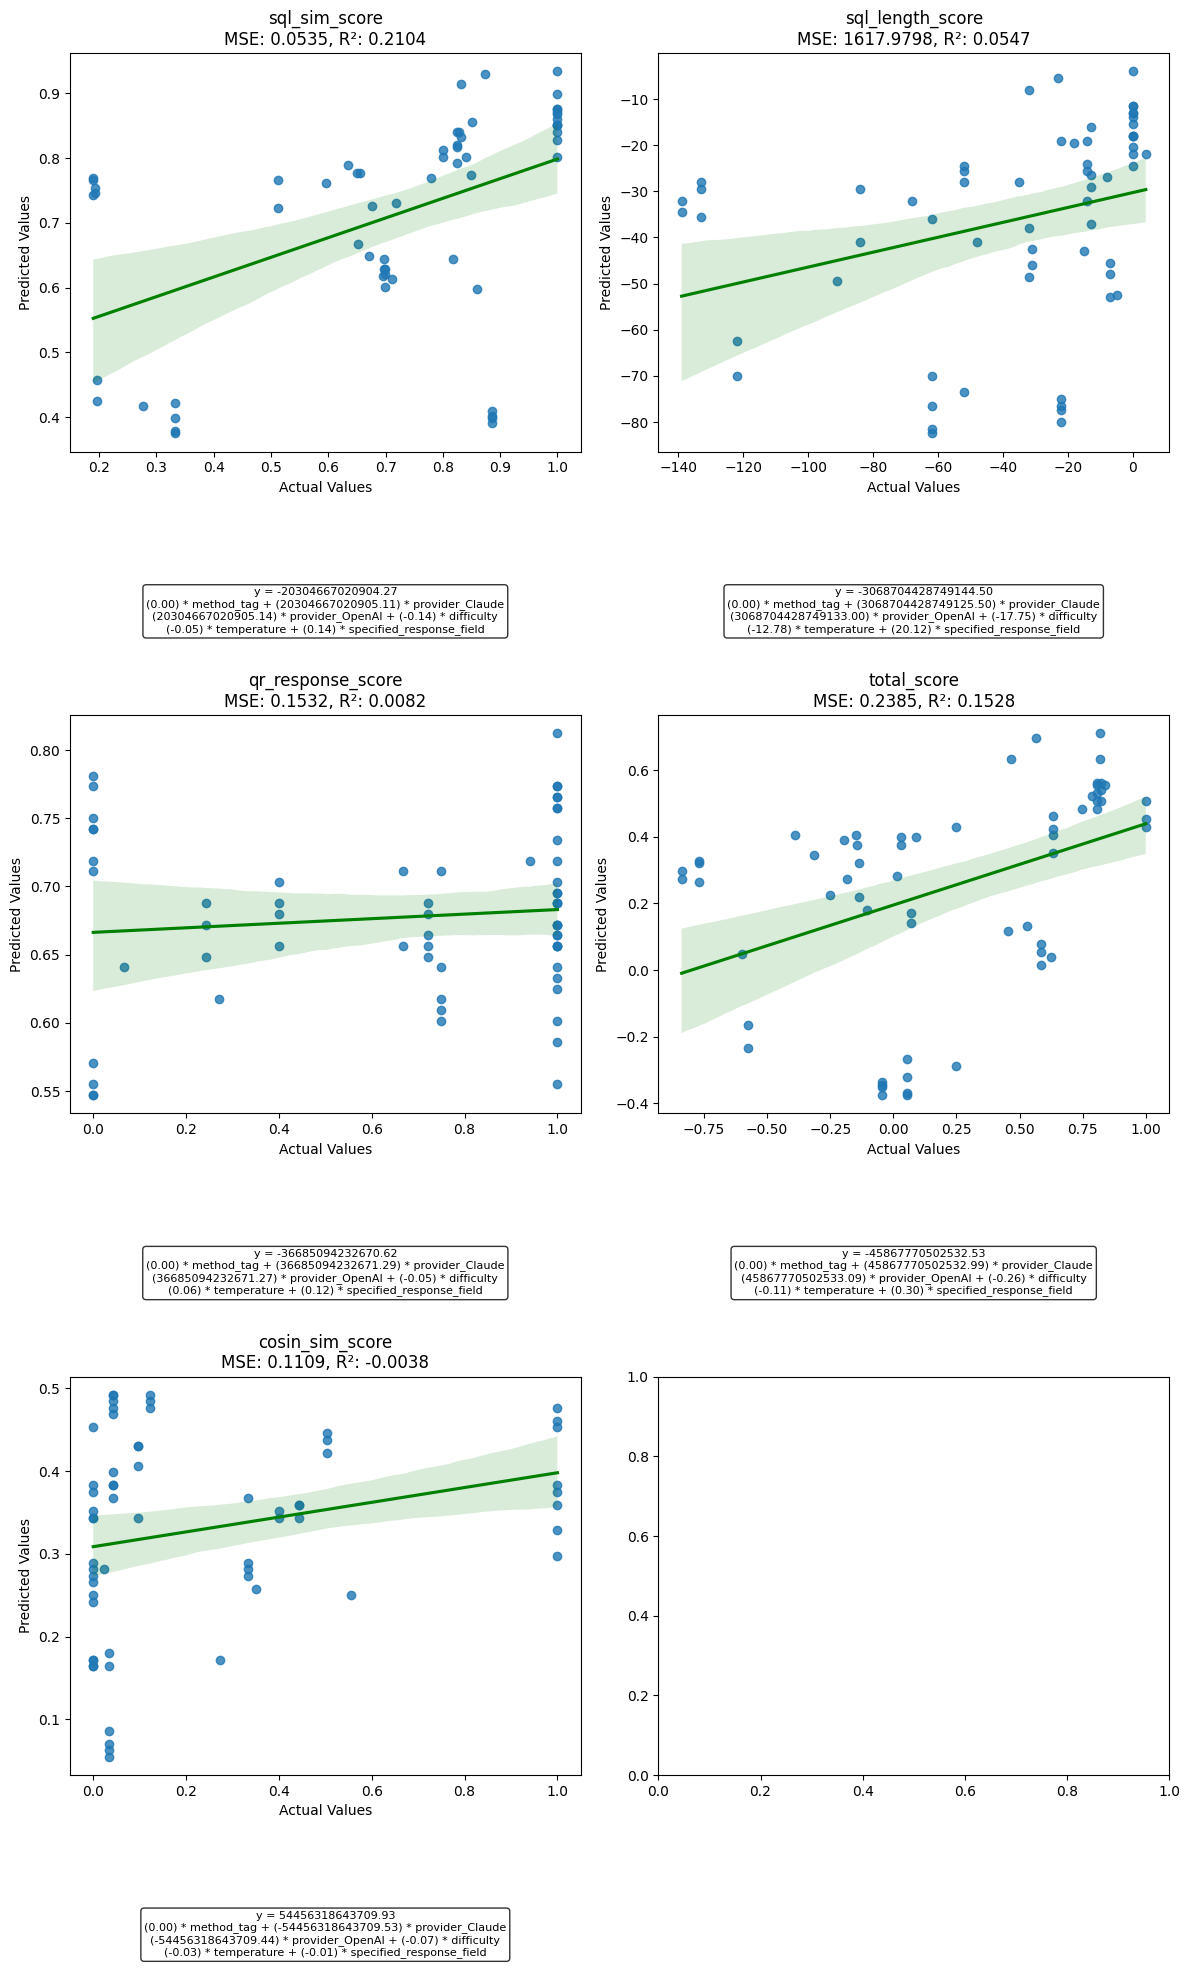

In [22]:
# Linear regression for: ['difficulty', 'method', 'provider', 'temperature']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['method', 'provider']),
    ],
    remainder='passthrough'  # Keep numerical and binary features as they are
)

def analyze_and_sub_plot(ax, response_var):

    X = sql_df[['difficulty', 'method', 'provider', 'temperature', 'specified_response_field']]
    y = sql_df[response_var]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    transformed_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    passthrough_features = ['difficulty', 'temperature', 'specified_response_field']  # Manually add passthrough features
    all_feature_names = list(transformed_feature_names) + passthrough_features
    coefficients = pipeline.named_steps['regressor'].coef_
    intercept = pipeline.named_steps['regressor'].intercept_
  
    terms = [f"({coef:.2f}) * {feature}" for feature, coef in zip(all_feature_names, coefficients)]
    formula_lines = [f"y = {intercept:.2f}"]
    for i in range(0, len(terms), 2):  # Group terms in chunks of 2
        formula_lines.append(" + ".join(terms[i:i + 2]))
    formatted_formula = "\n".join(formula_lines)  # Join lines with explicit line breaks

    print("current formula: ", formatted_formula)

    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    sns.regplot(data=results_df, x='Actual', y='Predicted', ax=ax, line_kws={'color': 'green'})
    ax.set_title(f'{response_var}\nMSE: {mse:.4f}, R²: {r2:.4f}')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    
    ax.text(
        0.5, -0.4, formatted_formula, fontsize=8, ha='center', va='center', transform=ax.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )


fig, axes = plt.subplots(3, 2, figsize=(12, 20))  # 2x2 layout for 4 response variables

response_variables = ['sql_sim_score', 'sql_length_score', 'qr_response_score', 'total_score', 'cosin_sim_score']

for i, var in enumerate(response_variables):
    row, col = divmod(i, 2)
    analyze_and_sub_plot(axes[row, col], var)

plt.tight_layout()
plt.show()